In [1]:
import numpy as np
import gzip
import requests
import matplotlib.pyplot as plt
plt.style.use('./az-paper-twocol.mplstyle')

# Getting 1961-1990 HadISST1 SST data in ASCII format
file_url = 'https://www.metoffice.gov.uk/hadobs/hadisst/data/HadISST1_SST_1961-1990.txt.gz'

# This is pretty brute force, but it works without needing to download locally
data = []
headers = []

with requests.get(file_url, stream=True) as r:
    extracted = gzip.decompress(r.content)
    for i, line in enumerate(extracted.decode('utf-8').split('\n')):
        if i % 181 != 0:
            # Data is seperated every 6 characters
            split_line = [(line[k:k+6]).strip() for k in range(0, len(line), 6)]
            data.append(split_line)
        else:
            split_line = line.split()
            headers.append(split_line)

# Convert data to numpy array w/ int
data = np.array(data)
data = data.astype(int)

# Convert headers to numpy array, remove last row (it's blank)
# and only keep first 3 columns. Day, Month, Year format
headers = np.array(headers[:-1])[:, :3]

### Data Format
1. Land is set to bit -32768
2. Temperatures are in units of C * 100
3. 100% sea-ice-covered flagged as -1000

#### Want to create a mask around data that is not needed, i.e. land and ice

In [2]:
# This is now structured by month x latitude x longitude
data = data.reshape((360, 180, 360))

# Downsampling from (180, 360) to (90, 180)
data = data[:,::2,::2]

# Weight by latitude, W = sqrt(cos(lat))
weights = np.sqrt(np.cos(np.deg2rad(np.linspace(89.5, -89.5, data.shape[1]))))
weight_arr = np.tile(weights, (data.shape[2], 1)).T
weight_arr = np.tile(weight_arr, (data.shape[0], 1))

# data = data.reshape((360, 180*360)) # Flatten latitude and longitude
data = data.reshape((360, data.shape[1]*data.shape[2])) # Flatten latitude and longitude
weight_arr = weight_arr.reshape(data.shape)

# Weight by latitude, W = sqrt(cos(lat))
weights = np.sqrt(np.cos(np.deg2rad(np.linspace(89.5, -89.5, 90))))
weight_arr = np.tile(weights, (180, 1)).T
weight_arr = np.tile(weight_arr, (360, 1)).reshape(data.shape)


# Mask data where there is land (-32768), 100% ice cover (-1000), or -180
mask = np.logical_or(data == -32768, data == -1000, data == -180)
masked_data = np.ma.masked_array(data, mask)

masked_data = masked_data.astype(float)

### Remove Seasonal Variation

In [3]:
# Start by looping over 12 months. We'll calculate the month-by-month mean and subtract it from the data
# to get only the anomalies for each month

for month in range(12):

    # Get the data for the month
    month_data = masked_data[month::12, :]

    # Calculate the mean for the month
    month_mean = np.ma.mean(month_data, axis=0)

    # Subtract the mean from the data
    masked_data[month::12, :] -= month_mean

In [4]:
# Multiply by the weights
masked_data = masked_data * weight_arr

### Center the data

In [6]:
# Calculate mean of each location
mean = np.ma.mean(masked_data, axis=0)

# Calculate weighted mean of each location
x_tilde = masked_data - mean

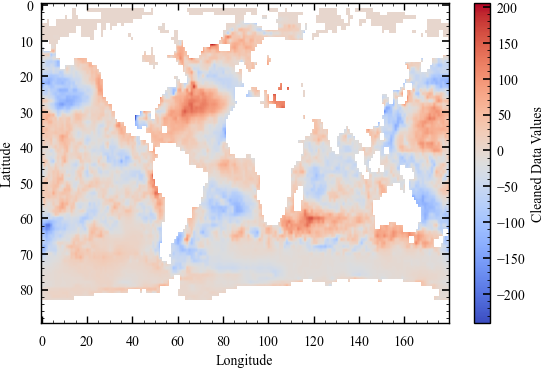

In [9]:
plt.imshow(x_tilde.reshape((360,90,180))[0,:,:], cmap='coolwarm', aspect='auto')

plt.colorbar(label='Cleaned Data Values')

plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

In [7]:
cov = np.ma.dot(x_tilde.T, x_tilde) / (masked_data.shape[1] - 1)

In [10]:
from numpy.linalg import eig
eig_vals, eig_vecs = eig(cov)

In [35]:
# We first make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[i,:]) for i in range(len(eig_vals))]

# Then, we sort the tuples from the highest to the lowest based on eigenvalues magnitude
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# For further usage
eig_vals_sorted = np.array([x[0] for x in eig_pairs])
eig_vecs_sorted = np.array([x[1] for x in eig_pairs])

In [36]:
# Explained variance
explained_variance = eig_vals_sorted / np.sum(eig_vals_sorted)

# Cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance)

(0.0, 10.0)

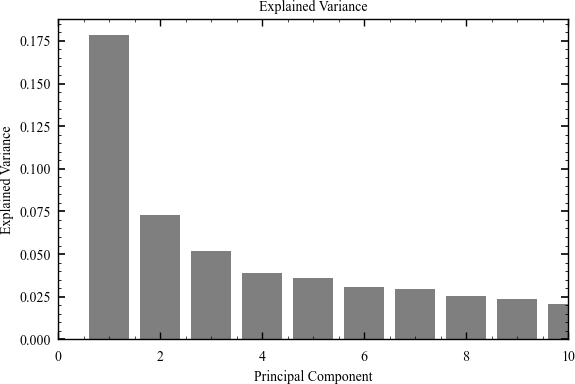

In [39]:
# Plot explained variance as a bar
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center', label='Individual explained variance')

plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.title('Explained Variance')

plt.xlim(0, 10)

(0.0, 100.0)

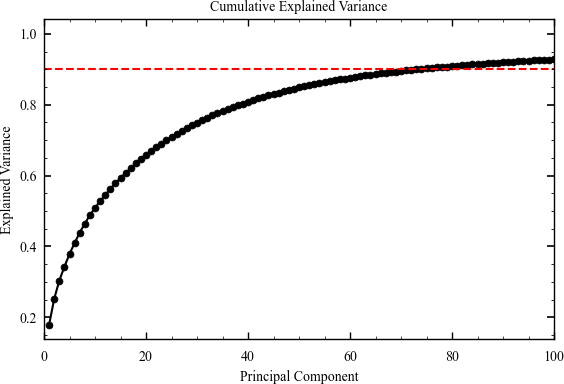

In [45]:
# Plot cumulative explained variance as a line
plt.plot(range(1, len(explained_variance) + 1), cumulative_explained_variance, marker='o', color='k', label='Cumulative explained variance')
plt.axhline(y=0.9, color='r', linestyle='--', label=r'90% Explained Variance')

plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.title('Cumulative Explained Variance')

plt.xlim(0, 100)